Exercise 1. JIT the Mandelbrot fractal
--------------------------------------------

Separate exercise notebook or use your own Mandelbrot code 

1. Profile the code, find the bottlenecks
2. Use Numba to speed up the code
3. Compare the timing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import njit
%matplotlib inline

In [21]:
def julia(c=0, xres=300, yres=300, xmin=-1.3, xmax=1.3, ymin=-1.3, ymax=1.3, zmax = 1, iterations = 250):
    
    julia = np.zeros((xres,yres))
    width = xmax - xmin
    height = ymax - ymin
    counter = 0

    for ys in range(yres):
        for xs in range(xres):
            z = complex(ys/yres*height + ymin, xs/xres*width + xmin)
            
            i = 0
            while i<=iterations and abs(z)<zmax:          
                z = z**2 + c
                i += 1
                counter += 1
            ratio = i/iterations
            julia[xs,ys] = ratio
            #if abs(z) < zmax:
                #julia[xs,ys] = 0
            #else:
                #julia[xs,ys] = 1
    return  counter
    

In [13]:
import cProfile

cProfile.run('julia()')

         10546255 function calls in 9.551 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    7.191    7.191    9.551    9.551 1839207562.py:1(julia)
        1    0.000    0.000    9.551    9.551 <string>:1(<module>)
 10546250    2.360    0.000    2.360    0.000 {built-in method builtins.abs}
        1    0.000    0.000    9.551    9.551 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [17]:
%load_ext snakeviz

In [18]:
%snakeviz julia()

 
*** Profile stats marshalled to file 'C:\\Users\\ivang\\AppData\\Local\\Temp\\tmp85v3re21'.
Embedding SnakeViz in this document...


In [22]:
numba_julia = njit()(julia)

In [28]:
plain = %timeit -o julia()
jitted = %timeit -o numba_julia()
print(plain.best / jitted.best)

5.95 s ± 67.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
77.3 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
92.59406879443091


In [27]:
iterations = np.arange(100,350, 25)
res = list()
tim = list()
res_num = list()
tim_num = list()
for i in iterations:
    a = %timeit -o -r 2 c = julia(iterations = i)
    tim.append(a.best)
    res.append(julia(iterations = i))
    
    b = %timeit -o -r 2 d = numba_julia(iterations = i)
    tim_num.append(b.best)
    res_num.append(numba_julia(iterations = i))

2.74 s ± 37.9 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
32.2 ms ± 1.23 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
3.24 s ± 81.9 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
44.1 ms ± 583 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
4.27 s ± 384 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
53.4 ms ± 1.09 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
4.41 s ± 88 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
53.9 ms ± 755 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
5.84 s ± 562 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
67.5 ms ± 7.64 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
6.69 s ± 380 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
69.5 ms ± 1.1 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
8.18 s ± 277 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
88 ms ± 849 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
8.71 s ± 1.08 s per loop (mean ± std. d

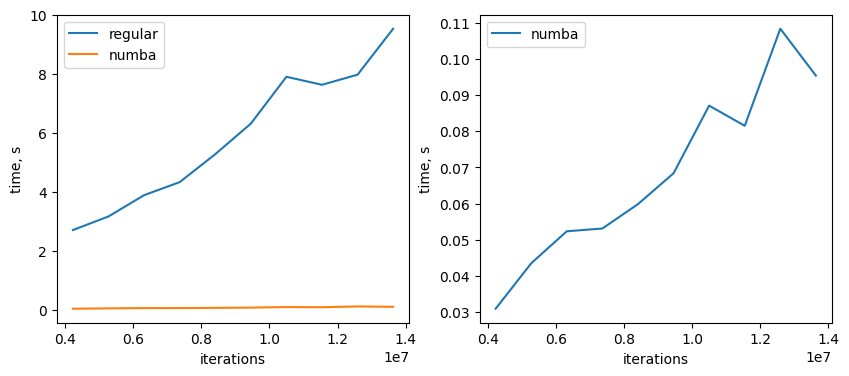

In [57]:
fig,axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(res,tim, label = 'regular')
axes[0].plot(res_num,tim_num, label = 'numba')
axes[1].plot(res_num,tim_num, label = 'numba')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('time, s')
axes[1].set_xlabel('iterations')
axes[1].set_ylabel('time, s');

## N-Body problems

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.

In [83]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * numpy.random.random()
        self.y = domain * numpy.random.random()
        self.z = domain * numpy.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [84]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

Now we create a list of `n` random particles, define a function to calculate their interaction via direct summation and run!

In [87]:
n = 10
particles = [Particle(m = 1 / n) for i in range(n)]

In [86]:
particles[10].z

0.31771382602978526

In [90]:
particles[1].z

0.03471162183668952

In [50]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

## How do we use Numba on this problem?
Problem: Numba doesn't support jitting native Python classes.  There is a `jit_class` structure in Numba but it's still in early development.

But it's nice to have attributes for literate programming.

Solution: NumPy custom dtypes.

In [58]:
particle_dtype = numpy.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[numpy.double, 
                                        numpy.double, 
                                        numpy.double, 
                                        numpy.double, 
                                        numpy.double]})

In [59]:
myarray = numpy.ones(3, dtype=particle_dtype)

In [60]:
myarray[1]["z"]

1.0

In [61]:
myarray['x']=numpy.ones(3)*10

In [62]:
myarray

array([(10., 1., 1., 1., 1.), (10., 1., 1., 1., 1.),
       (10., 1., 1., 1., 1.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

### Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * numpy.random.random()
```

In [194]:

def create_n_random_particles(n, m, domain=1):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = numpy.zeros((n), dtype=particle_dtype)
    
    for i in range(n):
        parts[i]['x'] = np.random.random()*domain
        parts[i]['y'] = np.random.random()*domain
        parts[i]['z'] = np.random.random()*domain
        parts[i]['m'] = m
        parts[i]['phi'] = 0
    
    return parts   #parts is an array of particles

In [195]:
parts = create_n_random_particles(5, 2, domain=1)

In [200]:
jit_parts = njit()(create_n_random_particles)
jit_par = jit_parts(5,2)

### Exercise 2

Write a JITted function `distance` to calculate the distance between two particles of dtype `particle_dtype`

Here's the `distance` method from the `Particle` class as a reference:

```python
def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5
```

In [197]:
def distance(part1, part2):
    '''calculate the distance between two particles'''
    return ((part1['x']-part2['x'])**2 + (part1['y']-part2['y'])**2 + (part1['z']-part2['z'])**2)**.5


In [271]:
distance(parts[0], parts[1])

0.41795978560227526

In [272]:
jit_dist = njit()(distance)
jit_dist(jit_par[0],jit_par[1])

0.7724826070925548

### Exercise 3
Modify the original `direct_sum` function (copied below for reference) to instead work a NumPy array of particles.  Loop over each element in the array and calculate its total potential.

```python
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [203]:
def direct_sum(particles):
    phi_list = list()
    for i, target in enumerate(particles):
        phi = 0
        for source in np.delete(particles,i,0):
            r = distance(target, source)
            phi += source["m"]/r
        phi_list.append(phi)
    return phi_list

In [204]:
direct_sum(parts)

[14.259383610674657,
 8.955631343888301,
 12.742597249677592,
 7.679614496030098,
 11.963761943626665]

In [266]:
def jit_direct_sum(particles):
    phi_list = list()
    for i, target in enumerate(particles):
        phi = 0
        mask = np.zeros((parts.shape[0]),dtype = np.int64)==0
        mask[i] = False
        pt = parts[mask]
        for source in pt:
            r = jit_dist(target, source)
            phi += source["m"]/r
        phi_list.append(phi)
    return phi_list

In [267]:
jit_sum = njit()(jit_direct_sum)

In [268]:
jit_sum(parts)

[14.259383610674657,
 8.955631343888301,
 12.742597249677592,
 7.679614496030098,
 11.963761943626665]

In [269]:
numbers = np.arange(2,52,4)
res = list()
tim = list()
res_num = list()
tim_num = list()
for n in numbers:
    parts = jit_parts(n,2)
    a = %timeit -o -r 2 c = direct_sum(parts)
    tim.append(a.best)
    res.append(n)
    
    b = %timeit -o -r 2 d = jit_sum(parts)
    tim_num.append(b.best)
    res_num.append(n)
    

45.4 µs ± 2.61 µs per loop (mean ± std. dev. of 2 runs, 10,000 loops each)
3.04 µs ± 106 ns per loop (mean ± std. dev. of 2 runs, 100,000 loops each)
453 µs ± 165 µs per loop (mean ± std. dev. of 2 runs, 1,000 loops each)
7.74 µs ± 1.45 µs per loop (mean ± std. dev. of 2 runs, 100,000 loops each)
997 µs ± 57.6 µs per loop (mean ± std. dev. of 2 runs, 1,000 loops each)
11.7 µs ± 1.33 µs per loop (mean ± std. dev. of 2 runs, 100,000 loops each)
1.3 ms ± 30.9 µs per loop (mean ± std. dev. of 2 runs, 1,000 loops each)
9.66 µs ± 165 ns per loop (mean ± std. dev. of 2 runs, 100,000 loops each)
2.3 ms ± 275 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)
11.7 µs ± 38.8 ns per loop (mean ± std. dev. of 2 runs, 100,000 loops each)
3.03 ms ± 49 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)
14.2 µs ± 80.5 ns per loop (mean ± std. dev. of 2 runs, 100,000 loops each)
4.19 ms ± 146 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)
20.6 µs ± 2.93 µs per loop (mean ± std. de

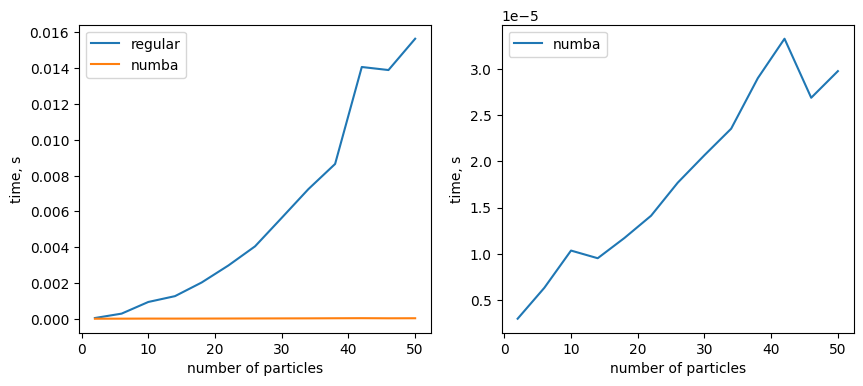

In [270]:
fig,axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(res,tim, label = 'regular')
axes[0].plot(res_num,tim_num, label = 'numba')
axes[1].plot(res_num,tim_num, label = 'numba')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('number of particles')
axes[0].set_ylabel('time, s')
axes[1].set_xlabel('number of particles')
axes[1].set_ylabel('time, s');